In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import matplotlib as mpl
import momlevel as ml
import gcsfs
import zarr
from matplotlib.ticker import FormatStrFormatter

In [2]:
def south_pole_map(cols=1, rows=1, fig_size=(12,8), max_extent=-50, facecolor='white'):
    ''' 
    User note: In order to call the function, begin cell with: fig, ax = south_pole_map(**args).
    
    Neglecting "fig, ax =" at the begeinning will not map your data to the existing axes.
    
    This function sets up a polar projection centered at the South Pole, which DataArrays can be plotted over.
    
    Optional arguments accepted for figure size, maximum (northward) extent and facecolor. Any number of columns and/or rows are also accepted for multiple subplots.
    
    If creating multiple subplots, ax=ax[*index*] must be passed in the plot call for each array.
    
    By default, these are set to (12,8), -50ºS and gray, respectively. Columns/Rows set to 1 by default – specifying axes in which to plot data is not necessary when using default column number.
    '''
    import matplotlib.path as mpath
    import numpy as np
    import cartopy.crs as ccrs
    
    fig,ax = plt.subplots(figsize=fig_size, ncols=cols, nrows=rows, subplot_kw={'projection': ccrs.SouthPolarStereo(), 'facecolor':facecolor}, layout='constrained')

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    if rows>1 and cols>1:
        for i in range(rows):
            for j in range(cols):
                ax[i,j].set_boundary(circle, transform=ax[i,j].transAxes)

                # lat/long map extents. shows south pole out to 50ºS
                ax[i,j].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif cols>1 and rows==1:
        for i in range(cols):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)

            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif rows>1 and cols==1:
        for i in range(rows):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)

            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    else:
        ax.set_boundary(circle, transform=ax.transAxes)

            # lat/long map extents. shows south pole out to 50ºS
        ax.set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    
    
    #must return fig, ax when creating multiple subplots in a function
    return fig, ax

# <span style="color:red">Importing Data Sets</span>

In [3]:
mask_CM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/CM4_mask_antarctica.nc')
mask_ESM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ESM4_mask_antarctica.nc')
mask_ERA5= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ERA5_mask_antarctica.nc')

In [4]:
mask_ERA5


<xarray.Dataset>
Dimensions:         (longitude: 720, latitude: 361)
Coordinates:
  * longitude       (longitude) float32 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
  * latitude        (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
    number          int32 ...
    time            datetime64[ns] ...
Data variables:
    orog            (latitude, longitude) float32 ...
    ross_ERA5       (latitude, longitude) float32 ...
    filchner_ERA5   (latitude, longitude) float32 ...
    peninsula_ERA5  (latitude, longitude) float32 ...
    loweast_ERA5    (latitude, longitude) float32 ...
    lowwest_ERA5    (latitude, longitude) float32 ...
    plateau_ERA5    (latitude, longitude) float32 ...

In [5]:
temperature_pi_ESM4 = xr.open_mfdataset("/backup/tuq41374/model_output/cmip6/piControl/gfdl_esm4/atmos/monthly/temp/*.nc", 
                          chunks={'time':1,'z_l':1},drop_variables=['average_DT', 'average_T1', 'average_T2'],)

temperature_pi_CM4 = xr.open_mfdataset("/backup/tuq41374/model_output/cmip6/piControl/gfdl_cm4/atmos/monthly/temp/*.nc", 
                          chunks={'time':1,'z_l':1},drop_variables=['average_DT', 'average_T1', 'average_T2'],)

observational_temp= xr.open_dataset('//home/tu.temple.edu/tuo59681/era5/temp/era5_2m_temperature_1940-2024_monthly_ensemble.nc')

In [6]:
ERA5_observational_temp=observational_temp.t2m

In [7]:
ERA5_observational_temp=observational_temp.t2m

In [8]:
#combining the expver 1 and 5 values into one data set to remove the dimension
ERA5_combine =ERA5_observational_temp.sel(expver=1).combine_first(ERA5_observational_temp.sel(expver=5))
ERA5_combine.load()

<xarray.DataArray 't2m' (time: 1013, number: 10, latitude: 361, longitude: 720)>
array([[[[249.01538, 249.01538, 249.01538, ..., 249.01538, 249.01538,
          249.01538],
         [249.35663, 249.35843, 249.36023, ..., 249.35301, 249.35483,
          249.35663],
         [249.64009, 249.64369, 249.64731, ..., 249.62926, 249.63286,
          249.63467],
         ...,
         [244.36626, 244.36446, 244.36264, ..., 244.37529, 244.37167,
          244.36987],
         [244.07196, 244.07016, 244.07016, ..., 244.07738, 244.07738,
          244.07558],
         [243.3931 , 243.3931 , 243.3931 , ..., 243.3931 , 243.3931 ,
          243.3931 ]],

        [[245.31233, 245.31233, 245.31233, ..., 245.31233, 245.31233,
          245.31233],
         [245.63191, 245.63551, 245.63733, ..., 245.62468, 245.6265 ,
          245.6301 ],
         [245.993  , 245.99841, 246.00565, ..., 245.97495, 245.98218,
          245.98758],
...
         [256.00262, 256.00262, 256.00262, ..., 256.00262, 256.00262,
          256.00262],
         [256.00262, 256.00262, 256.00262, ..., 256.00262, 256.00262,
          256.00262],
         [256.00262, 256.00262, 256.00262, ..., 256.00262, 256.00262,
          256.00262]],

        [[256.00262, 256.00262, 256.00262, ..., 256.00262, 256.00262,
          256.00262],
         [256.00262, 256.00262, 256.00262, ..., 256.00262, 256.00262,
          256.00262],
         [256.00262, 256.00262, 256.00262, ..., 256.00262, 256.00262,
          256.00262],
         ...,
         [256.00262, 256.00262, 256.00262, ..., 256.00262, 256.00262,
          256.00262],
         [256.00262, 256.00262, 256.00262, ..., 256.00262, 256.00262,
          256.00262],
         [256.00262, 256.00262, 256.00262, ..., 256.00262, 256.00262,
          256.00262]]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * time       (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2024-05-01
Attributes:
    units:      K
    long_name:  2 metre temperature

In [9]:
temp_CM4 = temperature_pi_CM4.temp
temp_ESM4 = temperature_pi_ESM4.temp
temp_ERA5=ERA5_combine.mean('number').sel(time=slice('1979-01-01','2018-12-01'))
#removing number dimension and slicing for same time period as precipitation

In [10]:
temp_ERA5

<xarray.DataArray 't2m' (time: 480, latitude: 361, longitude: 720)>
array([[[244.6571 , 244.6571 , 244.6571 , ..., 244.6571 , 244.6571 ,
         244.6571 ],
        [245.17188, 245.16463, 245.15689, ..., 245.18704, 245.18181,
         245.17656],
        [245.28723, 245.27226, 245.25671, ..., 245.31845, 245.30856,
         245.29936],
        ...,
        [244.12776, 244.12595, 244.12375, ..., 244.13516, 244.13315,
         244.13103],
        [243.85583, 243.85477, 243.85388, ..., 243.85873, 243.85783,
         243.85674],
        [243.15462, 243.15462, 243.15462, ..., 243.15462, 243.15462,
         243.15462]],

       [[241.44661, 241.44661, 241.44661, ..., 241.44661, 241.44661,
         241.44661],
        [241.8346 , 241.82683, 241.81943, ..., 241.85466, 241.84814,
         241.84128],
        [241.89563, 241.87903, 241.86441, ..., 241.93735, 241.92343,
         241.91025],
...
        [236.6554 , 236.6478 , 236.64114, ..., 236.6794 , 236.672  ,
         236.66406],
        [236.67325, 236.67036, 236.66695, ..., 236.68465, 236.6805 ,
         236.67688],
        [236.38835, 236.38835, 236.38835, ..., 236.38835, 236.38835,
         236.38835]],

       [[251.26953, 251.26953, 251.26953, ..., 251.26953, 251.26953,
         251.26953],
        [251.44522, 251.44736, 251.45047, ..., 251.43582, 251.43909,
         251.44214],
        [251.43457, 251.43979, 251.44414, ..., 251.41199, 251.41867,
         251.42607],
        ...,
        [249.93835, 249.9322 , 249.925  , ..., 249.95805, 249.95117,
         249.94485],
        [249.75565, 249.75203, 249.74805, ..., 249.76595, 249.76212,
         249.75923],
        [249.227  , 249.227  , 249.227  , ..., 249.227  , 249.227  ,
         249.227  ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01

# <span style="color:red">Seasonal Slices-Slicing seasons for each data set to compare them</span>

In [11]:
temp_seasonal_CM4 = temp_CM4.groupby('time.season').mean(dim='time')
temp_summer_CM4= temp_seasonal_CM4.sel(season= 'DJF')
temp_winter_CM4=temp_seasonal_CM4.sel(season='JJA')
temp_spring_CM4=temp_seasonal_CM4.sel(season='SON')
temp_fall_CM4=temp_seasonal_CM4.sel(season='MAM')

In [12]:
temp_seasonal_ESM4 = temp_ESM4.groupby('time.season').mean(dim='time')
temp_summer_ESM4= temp_seasonal_ESM4.sel(season= 'DJF')
temp_winter_ESM4=temp_seasonal_ESM4.sel(season='JJA')
temp_spring_ESM4=temp_seasonal_ESM4.sel(season='SON')
temp_fall_ESM4=temp_seasonal_ESM4.sel(season='MAM')

In [13]:
temp_seasonal_ERA5 = temp_ERA5.groupby('time.season').mean(dim='time')
temp_summer_ERA5= temp_seasonal_ERA5.sel(season= 'DJF')
temp_winter_ERA5=temp_seasonal_ERA5.sel(season='JJA')
temp_spring_ERA5=temp_seasonal_ERA5.sel(season='SON')
temp_fall_ERA5=temp_seasonal_ERA5.sel(season='MAM')

# <span style="color:red">Applying masks to seasons</span>

In [14]:
plateau_temp_total_CM4=(temp_CM4*(mask_CM4.plateau_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon').mean(dim='time')
ross_temp_total_CM4=(temp_CM4*(mask_CM4.ross_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon').mean(dim='time')
lowwest_temp_total_CM4=(temp_CM4*(mask_CM4.lowwest_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon').mean(dim='time')
loweast_temp_total_CM4=(temp_CM4*(mask_CM4.loweast_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon').mean(dim='time')
filchner_temp_total_CM4=(temp_CM4*(mask_CM4.filchner_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon').mean(dim='time')
peninsula_temp_total_CM4=(temp_CM4*(mask_CM4.peninsula_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon').mean(dim='time')

plateau_temp_total_ESM4=(temp_ESM4*(mask_ESM4.plateau_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon').mean(dim='time')
ross_temp_total_ESM4=(temp_ESM4*(mask_ESM4.ross_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon').mean(dim='time')
lowwest_temp_total_ESM4=(temp_ESM4*(mask_ESM4.lowwest_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon').mean(dim='time')
loweast_temp_total_ESM4=(temp_ESM4*(mask_ESM4.loweast_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon').mean(dim='time')
filchner_temp_total_ESM4=(temp_ESM4*(mask_ESM4.filchner_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon').mean(dim='time')
peninsula_temp_total_ESM4=(temp_ESM4*(mask_ESM4.peninsula_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon').mean(dim='time')

plateau_temp_total_ERA5=(temp_ERA5*(mask_ERA5.plateau_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
ross_temp_total_ERA5=(temp_ERA5*(mask_ERA5.ross_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
lowwest_temp_total_ERA5=(temp_ERA5*(mask_ERA5.lowwest_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
loweast_temp_total_ERA5=(temp_ERA5*(mask_ERA5.loweast_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
filchner_temp_total_ERA5=(temp_ERA5*(mask_ERA5.filchner_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
peninsula_temp_total_ERA5=(temp_ERA5*(mask_ERA5.peninsula_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')


In [15]:
plateau_temp_summer_CM4=(temp_summer_CM4*(mask_CM4.plateau_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
ross_temp_summer_CM4=(temp_summer_CM4*(mask_CM4.ross_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
lowwest_temp_summer_CM4=(temp_summer_CM4*(mask_CM4.lowwest_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
loweast_temp_summer_CM4=(temp_summer_CM4*(mask_CM4.loweast_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
filchner_temp_summer_CM4=(temp_summer_CM4*(mask_CM4.filchner_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
peninsula_temp_summer_CM4=(temp_summer_CM4*(mask_CM4.peninsula_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')

plateau_temp_summer_ESM4=(temp_summer_ESM4*(mask_ESM4.plateau_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
ross_temp_summer_ESM4=(temp_summer_ESM4*(mask_ESM4.ross_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
lowwest_temp_summer_ESM4=(temp_summer_ESM4*(mask_ESM4.lowwest_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
loweast_temp_summer_ESM4=(temp_summer_ESM4*(mask_ESM4.loweast_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
filchner_temp_summer_ESM4=(temp_summer_ESM4*(mask_ESM4.filchner_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
peninsula_temp_summer_ESM4=(temp_summer_ESM4*(mask_ESM4.peninsula_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')

plateau_temp_summer_ERA5=(temp_summer_ERA5*(mask_ERA5.plateau_ERA5)).mean(dim='latitude').mean(dim='longitude')
ross_temp_summer_ERA5=(temp_summer_ERA5*(mask_ERA5.ross_ERA5)).mean(dim='latitude').mean(dim='longitude')
lowwest_temp_summer_ERA5=(temp_summer_ERA5*(mask_ERA5.lowwest_ERA5)).mean(dim='latitude').mean(dim='longitude')
loweast_temp_summer_ERA5=(temp_summer_ERA5*(mask_ERA5.loweast_ERA5)).mean(dim='latitude').mean(dim='longitude')
filchner_temp_summer_ERA5=(temp_summer_ERA5*(mask_ERA5.filchner_ERA5)).mean(dim='latitude').mean(dim='longitude')
peninsula_temp_summer_ERA5=(temp_summer_ERA5*(mask_ERA5.peninsula_ERA5)).mean(dim='latitude').mean(dim='longitude')

In [16]:
plateau_temp_winter_CM4=(temp_winter_CM4*(mask_CM4.plateau_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
ross_temp_winter_CM4=(temp_winter_CM4*(mask_CM4.ross_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
lowwest_temp_winter_CM4=(temp_winter_CM4*(mask_CM4.lowwest_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
loweast_temp_winter_CM4=(temp_winter_CM4*(mask_CM4.loweast_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
filchner_temp_winter_CM4=(temp_winter_CM4*(mask_CM4.filchner_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
peninsula_temp_winter_CM4=(temp_winter_CM4*(mask_CM4.peninsula_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')

plateau_temp_winter_ESM4=(temp_winter_ESM4*(mask_ESM4.plateau_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
ross_temp_winter_ESM4=(temp_winter_ESM4*(mask_ESM4.ross_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
lowwest_temp_winter_ESM4=(temp_winter_ESM4*(mask_ESM4.lowwest_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
loweast_temp_winter_ESM4=(temp_winter_ESM4*(mask_ESM4.loweast_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
filchner_temp_winter_ESM4=(temp_winter_ESM4*(mask_ESM4.filchner_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
peninsula_temp_winter_ESM4=(temp_winter_ESM4*(mask_ESM4.peninsula_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')

plateau_temp_winter_ERA5=(temp_winter_ERA5*(mask_ERA5.plateau_ERA5)).mean(dim='latitude').mean(dim='longitude')
ross_temp_winter_ERA5=(temp_winter_ERA5*(mask_ERA5.ross_ERA5)).mean(dim='latitude').mean(dim='longitude')
lowwest_temp_winter_ERA5=(temp_winter_ERA5*(mask_ERA5.lowwest_ERA5)).mean(dim='latitude').mean(dim='longitude')
loweast_temp_winter_ERA5=(temp_winter_ERA5*(mask_ERA5.loweast_ERA5)).mean(dim='latitude').mean(dim='longitude')
filchner_temp_winter_ERA5=(temp_winter_ERA5*(mask_ERA5.filchner_ERA5)).mean(dim='latitude').mean(dim='longitude')
peninsula_temp_winter_ERA5=(temp_winter_ERA5*(mask_ERA5.peninsula_ERA5)).mean(dim='latitude').mean(dim='longitude')

In [17]:
plateau_temp_fall_CM4=(temp_fall_CM4*(mask_CM4.plateau_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
ross_temp_fall_CM4=(temp_fall_CM4*(mask_CM4.ross_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
lowwest_temp_fall_CM4=(temp_fall_CM4*(mask_CM4.lowwest_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
loweast_temp_fall_CM4=(temp_fall_CM4*(mask_CM4.loweast_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
filchner_temp_fall_CM4=(temp_fall_CM4*(mask_CM4.filchner_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
peninsula_temp_fall_CM4=(temp_fall_CM4*(mask_CM4.peninsula_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')

plateau_temp_fall_ESM4=(temp_fall_ESM4*(mask_ESM4.plateau_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
ross_temp_fall_ESM4=(temp_fall_ESM4*(mask_ESM4.ross_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
lowwest_temp_fall_ESM4=(temp_fall_ESM4*(mask_ESM4.lowwest_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
loweast_temp_fall_ESM4=(temp_fall_ESM4*(mask_ESM4.loweast_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
filchner_temp_fall_ESM4=(temp_fall_ESM4*(mask_ESM4.filchner_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
peninsula_temp_fall_ESM4=(temp_fall_ESM4*(mask_ESM4.peninsula_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')

plateau_temp_fall_ERA5=(temp_fall_ERA5*(mask_ERA5.plateau_ERA5)).mean(dim='latitude').mean(dim='longitude')
ross_temp_fall_ERA5=(temp_fall_ERA5*(mask_ERA5.ross_ERA5)).mean(dim='latitude').mean(dim='longitude')
lowwest_temp_fall_ERA5=(temp_fall_ERA5*(mask_ERA5.lowwest_ERA5)).mean(dim='latitude').mean(dim='longitude')
loweast_temp_fall_ERA5=(temp_fall_ERA5*(mask_ERA5.loweast_ERA5)).mean(dim='latitude').mean(dim='longitude')
filchner_temp_fall_ERA5=(temp_fall_ERA5*(mask_ERA5.filchner_ERA5)).mean(dim='latitude').mean(dim='longitude')
peninsula_temp_fall_ERA5=(temp_fall_ERA5*(mask_ERA5.peninsula_ERA5)).mean(dim='latitude').mean(dim='longitude')

In [18]:
plateau_temp_spring_CM4=(temp_spring_CM4*(mask_CM4.plateau_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
ross_temp_spring_CM4=(temp_spring_CM4*(mask_CM4.ross_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
lowwest_temp_spring_CM4=(temp_spring_CM4*(mask_CM4.lowwest_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
loweast_temp_spring_CM4=(temp_spring_CM4*(mask_CM4.loweast_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
filchner_temp_spring_CM4=(temp_spring_CM4*(mask_CM4.filchner_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')
peninsula_temp_spring_CM4=(temp_spring_CM4*(mask_CM4.peninsula_CM4)).mean(dim='pfull').mean(dim='lat').mean(dim='lon')

plateau_temp_spring_ESM4=(temp_spring_ESM4*(mask_ESM4.plateau_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
ross_temp_spring_ESM4=(temp_spring_ESM4*(mask_ESM4.ross_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
lowwest_temp_spring_ESM4=(temp_spring_ESM4*(mask_ESM4.lowwest_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
loweast_temp_spring_ESM4=(temp_spring_ESM4*(mask_ESM4.loweast_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
filchner_temp_spring_ESM4=(temp_spring_ESM4*(mask_ESM4.filchner_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')
peninsula_temp_spring_ESM4=(temp_spring_ESM4*(mask_ESM4.peninsula_ESM4)).mean(dim='level').mean(dim='lat').mean(dim='lon')

plateau_temp_spring_ERA5=(temp_spring_ERA5*(mask_ERA5.plateau_ERA5)).mean(dim='latitude').mean(dim='longitude')
ross_temp_spring_ERA5=(temp_spring_ERA5*(mask_ERA5.ross_ERA5)).mean(dim='latitude').mean(dim='longitude')
lowwest_temp_spring_ERA5=(temp_spring_ERA5*(mask_ERA5.lowwest_ERA5)).mean(dim='latitude').mean(dim='longitude')
loweast_temp_spring_ERA5=(temp_spring_ERA5*(mask_ERA5.loweast_ERA5)).mean(dim='latitude').mean(dim='longitude')
filchner_temp_spring_ERA5=(temp_spring_ERA5*(mask_ERA5.filchner_ERA5)).mean(dim='latitude').mean(dim='longitude')
peninsula_temp_spring_ERA5=(temp_spring_ERA5*(mask_ERA5.peninsula_ERA5)).mean(dim='latitude').mean(dim='longitude')

# <span style="color:red">Spatial Plots</span>

In [28]:
plateau_temp_total_CM4_spatial=(temp_CM4*(mask_CM4.plateau_CM4)).mean(dim='pfull').mean(dim='time')
ross_temp_total_CM4_spatial=(temp_CM4*(mask_CM4.ross_CM4)).mean(dim='pfull').mean(dim='time')
lowwest_temp_total_CM4_spatial=(temp_CM4*(mask_CM4.lowwest_CM4)).mean(dim='pfull').mean(dim='time')
loweast_temp_total_CM4_spatial=(temp_CM4*(mask_CM4.loweast_CM4)).mean(dim='pfull').mean(dim='time')
filchner_temp_total_CM4_spatial=(temp_CM4*(mask_CM4.filchner_CM4)).mean(dim='pfull').mean(dim='time')
peninsula_temp_total_CM4_spatial=(temp_CM4*(mask_CM4.peninsula_CM4)).mean(dim='pfull').mean(dim='time')

plateau_temp_total_ESM4_spatial=(temp_ESM4*(mask_ESM4.plateau_ESM4)).mean(dim='level').mean(dim='time')
ross_temp_total_ESM4_spatial=(temp_ESM4*(mask_ESM4.ross_ESM4)).mean(dim='level').mean(dim='time')
lowwest_temp_total_ESM4_spatial=(temp_ESM4*(mask_ESM4.lowwest_ESM4)).mean(dim='level').mean(dim='time')
loweast_temp_total_ESM4_spatial=(temp_ESM4*(mask_ESM4.loweast_ESM4)).mean(dim='level').mean(dim='time')
filchner_temp_total_ESM4_spatial=(temp_ESM4*(mask_ESM4.filchner_ESM4)).mean(dim='level').mean(dim='time')
peninsula_temp_total_ESM4_spatial=(temp_ESM4*(mask_ESM4.peninsula_ESM4)).mean(dim='level').mean(dim='time')

plateau_temp_total_ERA5_spatial=(temp_ERA5*(mask_ERA5.plateau_ERA5)).mean(dim='time')
ross_temp_total_ERA5_spatial=(temp_ERA5*(mask_ERA5.ross_ERA5)).mean(dim='time')
lowwest_temp_total_ERA5_spatial=(temp_ERA5*(mask_ERA5.lowwest_ERA5)).mean(dim='time')
loweast_temp_total_ERA5_spatial=(temp_ERA5*(mask_ERA5.loweast_ERA5)).mean(dim='time')
filchner_temp_total_ERA5_spatial=(temp_ERA5*(mask_ERA5.filchner_ERA5)).mean(dim='time')
peninsula_temp_total_ERA5_spatial=(temp_ERA5*(mask_ERA5.peninsula_ERA5)).mean(dim='time')

# <span style="color:red">Total Temp Plot</span>

In [21]:
plat_value_CM4_total=print(plateau_temp_total_CM4.values)
ross_value_CM4_total= print(ross_temp_total_CM4.values)
west_value_CM4_total=print(lowwest_temp_total_CM4.values)
east_value_CM4_total=print(loweast_temp_total_CM4.values)
filch_value_CM4_total=print(filchner_temp_total_CM4.values)
pen_value_CM4_total=print(peninsula_temp_total_CM4.values)

223.82227
233.96466
230.10686
233.02289
233.01022
238.5868


In [22]:
plat_value_ESM4_total=print(plateau_temp_total_ESM4.values)
ross_value_ESM4_total= print(ross_temp_total_ESM4.values)
west_value_ESM4_total=print(lowwest_temp_total_ESM4.values)
east_value_ESM4_total=print(loweast_temp_total_ESM4.values)
filch_value_ESM4_total=print(filchner_temp_total_ESM4.values)
pen_value_ESM4_total=print(peninsula_temp_total_ESM4.values)

227.58438
232.59732
230.62338
233.04433
232.42015
235.1494


In [23]:
plat_value_ERA5_total=print(plateau_temp_total_ERA5.values)
ross_value_ERA5_total= print(ross_temp_total_ERA5.values)
west_value_ERA5_total=print(lowwest_temp_total_ERA5.values)
east_value_ERA5_total=print(loweast_temp_total_ERA5.values)
filch_value_ERA5_total=print(filchner_temp_total_ERA5.values)
pen_value_ERA5_total=print(peninsula_temp_total_ERA5.values)

233.64595
244.37596
236.05264
255.37242
235.4064
255.26268


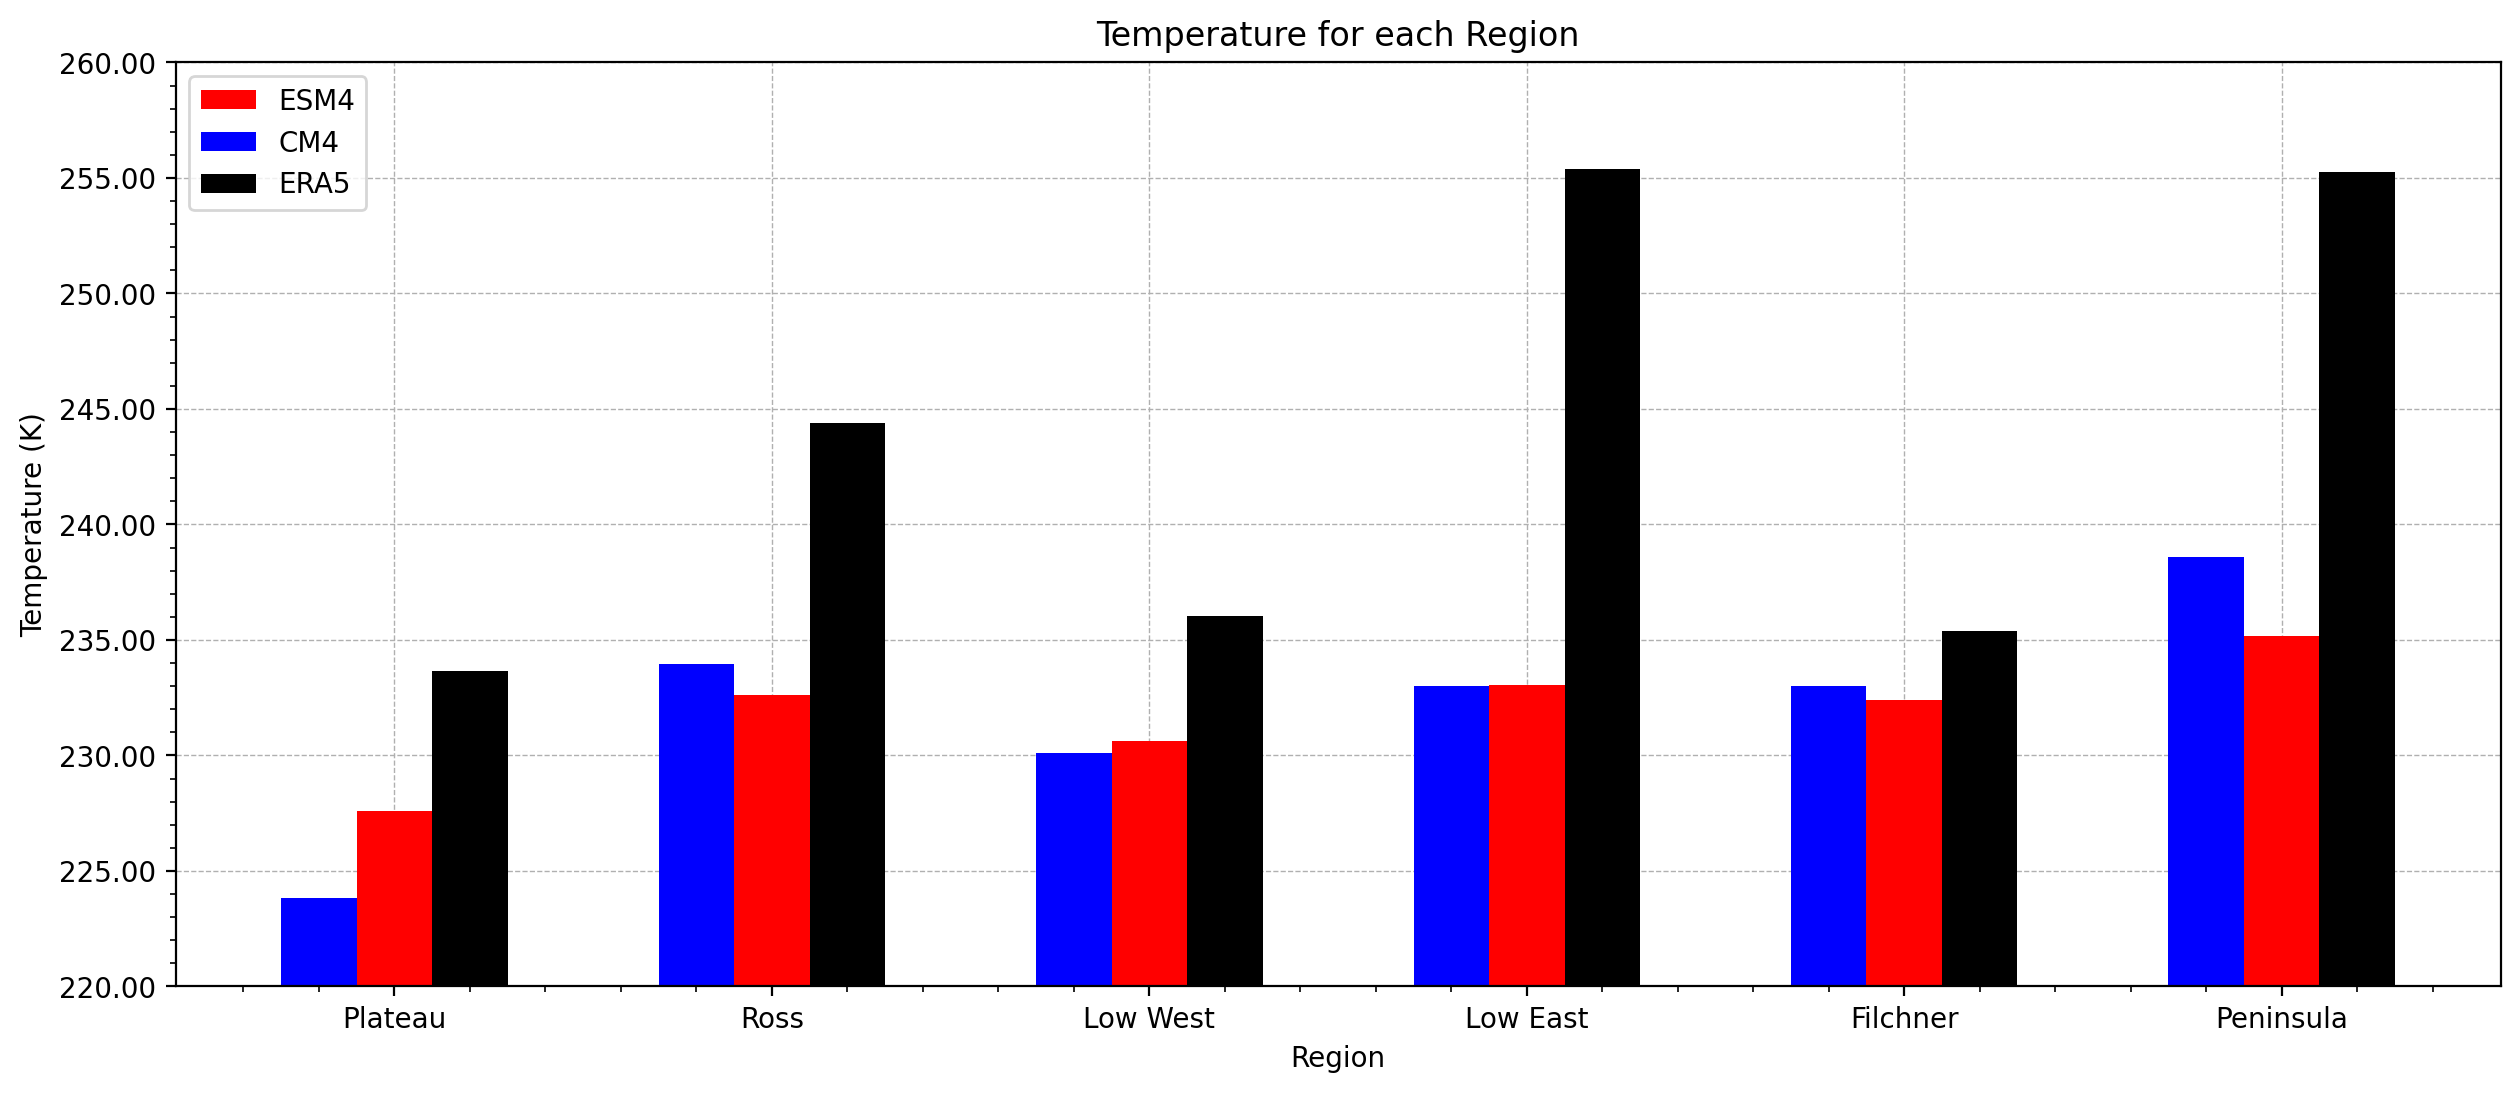

In [26]:

fig, ax= plt.subplots(figsize= (15,6))


X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4_total = [223.82227,
233.96466,
230.10686,
233.02289,
233.01022,
238.5868] 
ESM4_total = [227.58438,
232.59732,
230.62338,
233.04433,
232.42015,
235.1494
] 
ERA5_total=[
233.64595,
244.37596,
236.05264,
255.37242,
235.4064,
255.26268
 
]
X_axis = np.arange(len(X)) 
ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.bar(X_axis, ESM4_total, 0.2, label = 'ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4_total, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA5_total, 0.2, label= 'ERA5', color= 'k')
  
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Temperature (K)") 
plt.title("Temperature for each Region") 
plt.legend() 
plt.ylim(220,260)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.minorticks_on()
plt.show() 








Text(0.5, 0.98, 'Temperature (Kelvin)')

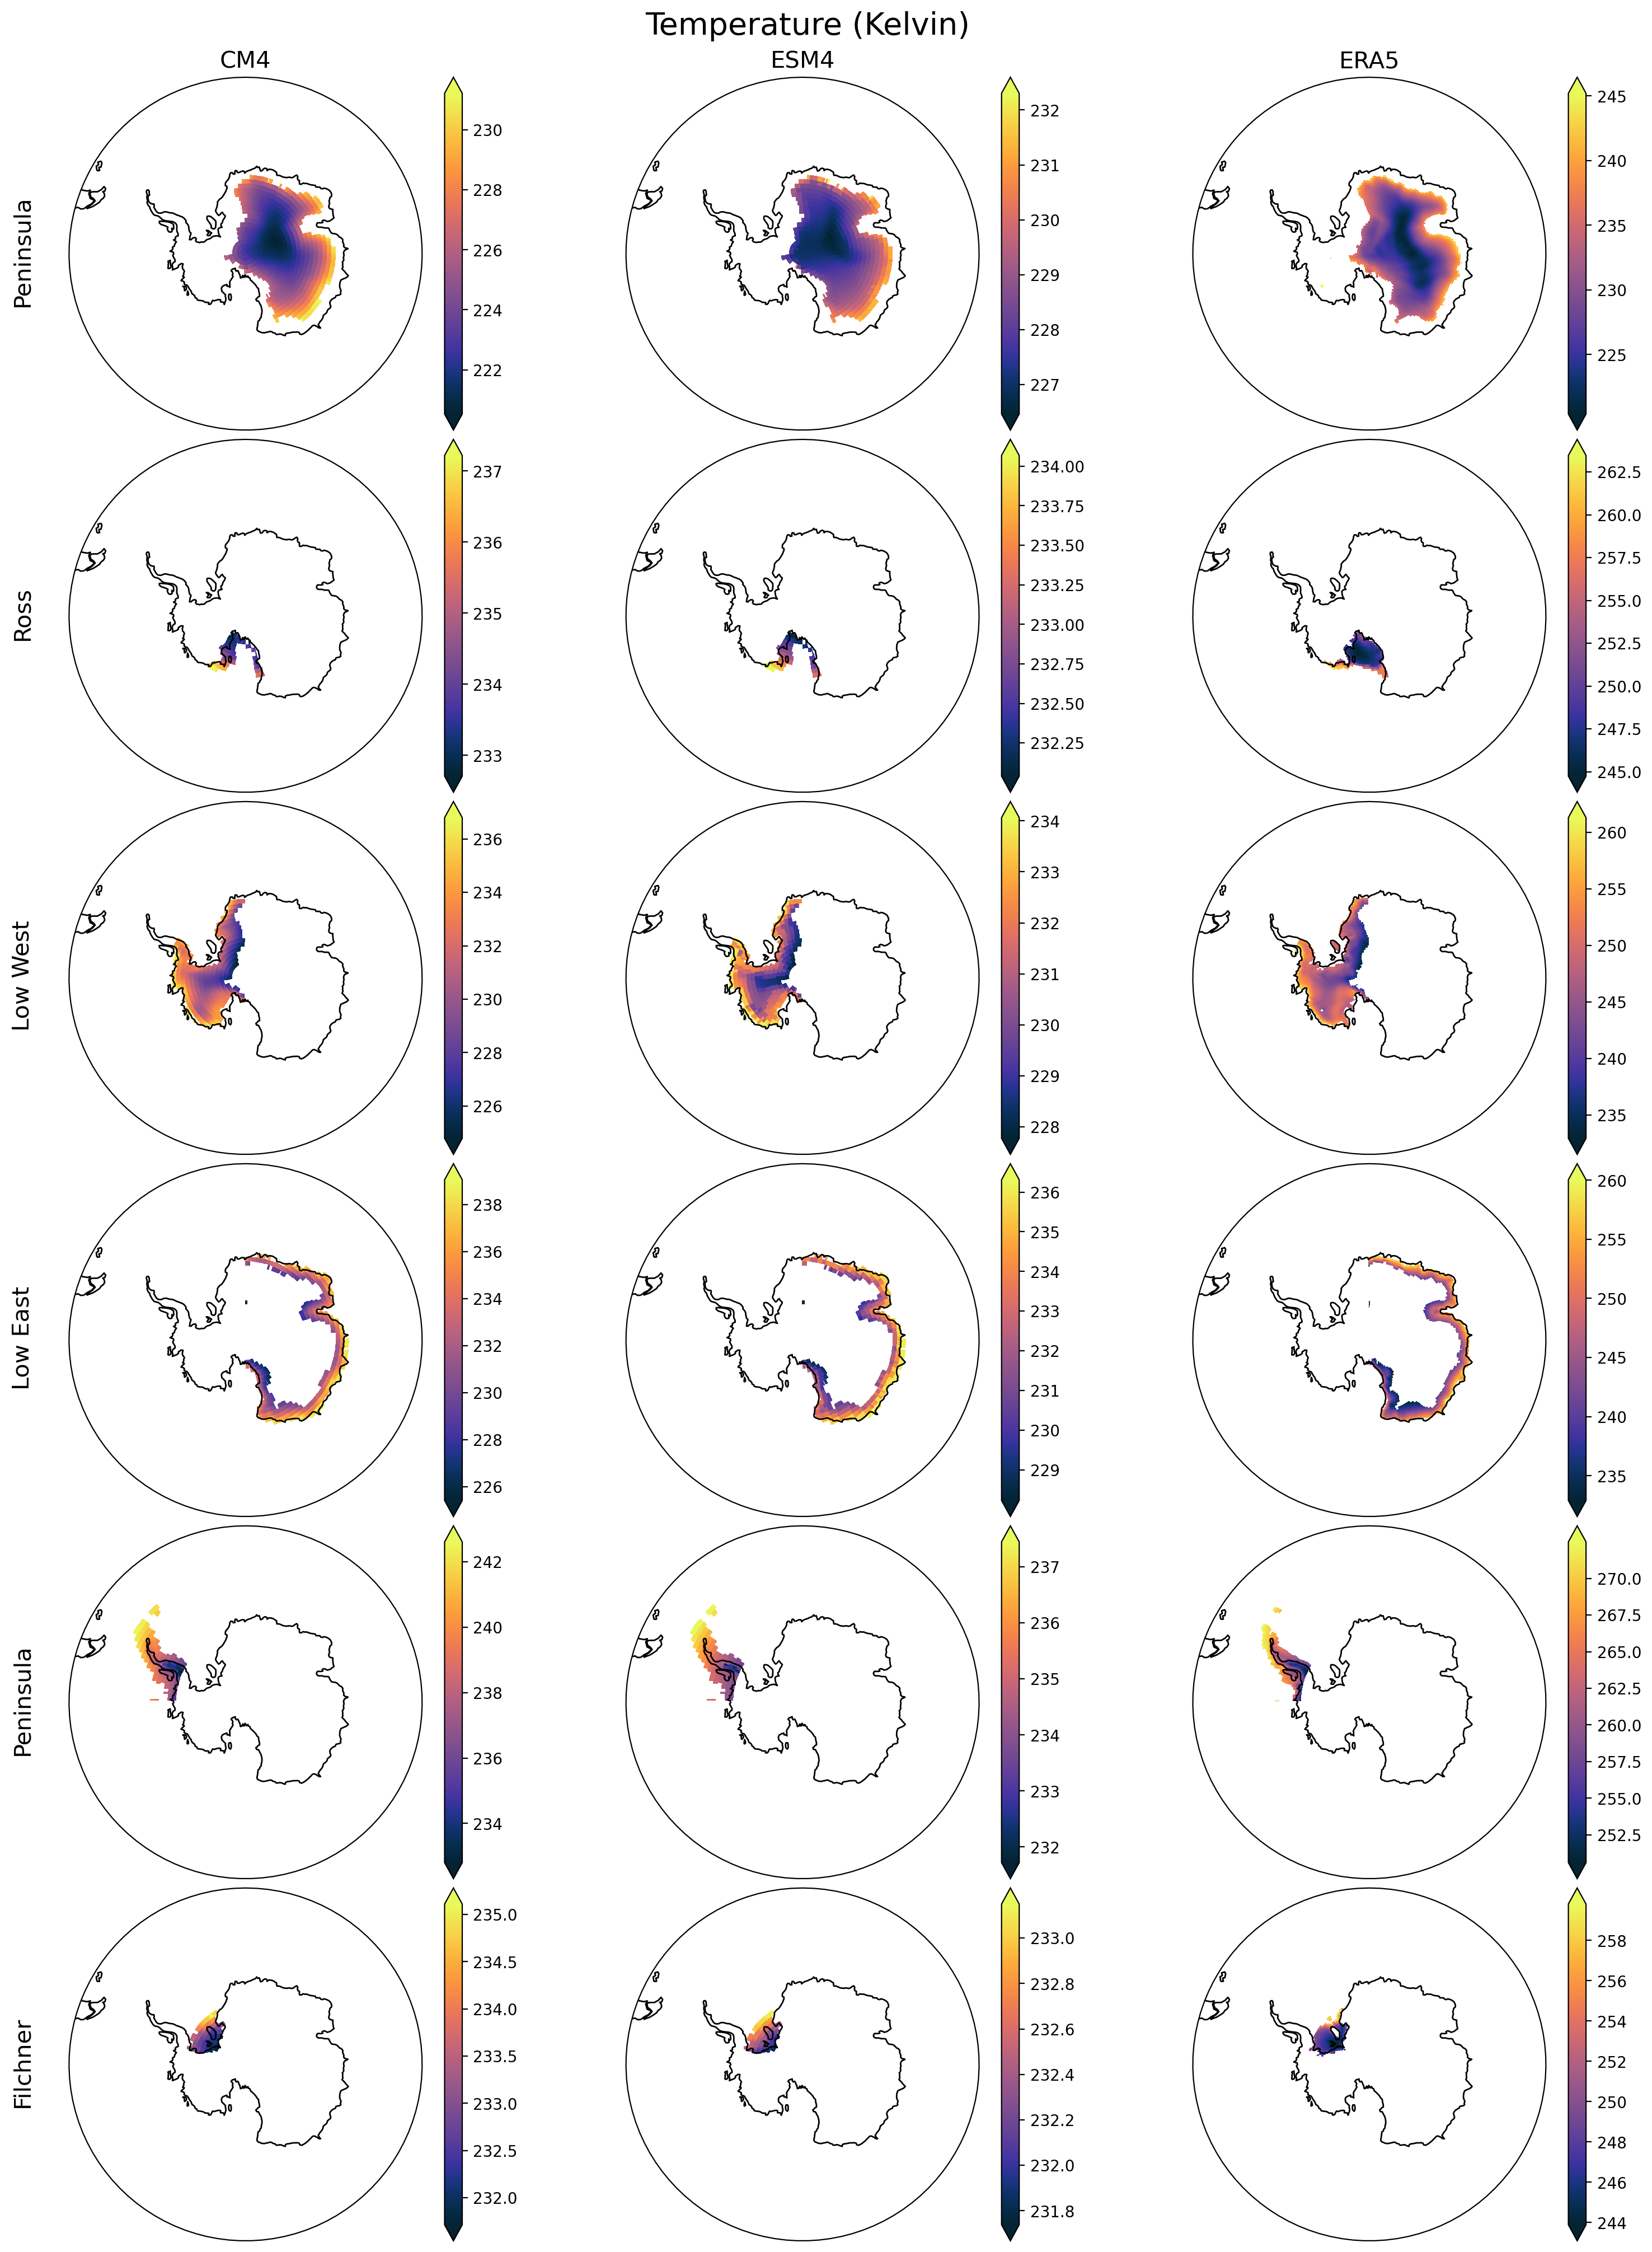

In [49]:
fig, ax = south_pole_map(cols=3, rows=6,fig_size=(15,20))



#CM4 Plots
plateau_temp_total_CM4_spatial.plot(ax=ax[0,0],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.thermal)
    
ross_temp_total_CM4_spatial.plot(ax=ax[1,0],
              transform =ccrs.PlateCarree(),
             
              extend='both',
              cmap=cmocean.cm.thermal)
lowwest_temp_total_CM4_spatial.plot(ax=ax[2,0],
               transform =ccrs.PlateCarree(),
               
               extend='both',
               cmap=cmocean.cm.thermal)
    
loweast_temp_total_CM4_spatial.plot(ax=ax[3,0],
            transform =ccrs.PlateCarree(),
              
               extend='both',
               cmap= cmocean.cm.thermal)
peninsula_temp_total_CM4_spatial.plot(ax=ax[4,0],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
filchner_temp_total_CM4_spatial.plot(ax=ax[5,0],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
#ESM4 Plots

plateau_temp_total_ESM4_spatial.plot(ax=ax[0,1],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.thermal)
    
ross_temp_total_ESM4_spatial.plot(ax=ax[1,1],
              transform =ccrs.PlateCarree(),
             
              extend='both',
              cmap=cmocean.cm.thermal)
lowwest_temp_total_ESM4_spatial.plot(ax=ax[2,1],
               transform =ccrs.PlateCarree(),
               
               extend='both',
               cmap=cmocean.cm.thermal)
    
loweast_temp_total_ESM4_spatial.plot(ax=ax[3,1],
            transform =ccrs.PlateCarree(),
              
               extend='both',
               cmap= cmocean.cm.thermal)
peninsula_temp_total_ESM4_spatial.plot(ax=ax[4,1],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
filchner_temp_total_ESM4_spatial.plot(ax=ax[5,1],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)

#ERA5 Plots
plateau_temp_total_ERA5_spatial.plot(ax=ax[0,2],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.thermal)
    
ross_temp_total_ERA5_spatial.plot(ax=ax[1,2],
              transform =ccrs.PlateCarree(),
             
              extend='both',
              cmap=cmocean.cm.thermal)
lowwest_temp_total_ERA5_spatial.plot(ax=ax[2,2],
               transform =ccrs.PlateCarree(),
               
               extend='both',
               cmap=cmocean.cm.thermal)
    
loweast_temp_total_ERA5_spatial.plot(ax=ax[3,2],
            transform =ccrs.PlateCarree(),
              
               extend='both',
               cmap= cmocean.cm.thermal)
peninsula_temp_total_ERA5_spatial.plot(ax=ax[4,2],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
filchner_temp_total_ERA5_spatial.plot(ax=ax[5,2],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
ax[0,0].coastlines()
ax[1,0].coastlines()
ax[2,0].coastlines()
ax[3,0].coastlines()
ax[4,0].coastlines()
ax[5,0].coastlines()

ax[0,1].coastlines()
ax[1,1].coastlines()
ax[2,1].coastlines()
ax[3,1].coastlines()
ax[4,1].coastlines()
ax[5,1].coastlines()

ax[0,2].coastlines()
ax[1,2].coastlines()
ax[2,2].coastlines()
ax[3,2].coastlines()
ax[4,2].coastlines()
ax[5,2].coastlines()

ax[0,0].set_title('CM4',size=15)
ax[0,1].set_title('ESM4',size=15)
ax[0,2].set_title('ERA5',size=15)

ax[1,2].set_title('')
ax[2,2].set_title('')
ax[3,2].set_title('')
ax[4,2].set_title('')
ax[5,2].set_title('')

rows = ['Peninsula', 'Ross', 'Low West', 'Low East', 'Peninsula', 'Filchner']

for ax, row in zip(ax[:,0], rows):
    ax.annotate(row, xy=(-30, 115), 
                xycoords='axes points', ha='center', va='center', color='k', rotation=90, fontsize=15)

fig.suptitle('Temperature (Kelvin)', fontsize=20)

# <span style="color:red">Summer Temp Plot </span>

In [27]:
plat_value_CM4_summer=print(plateau_temp_summer_CM4.values)
ross_value_CM4_summer= print(ross_temp_summer_CM4.values)
west_value_CM4_summer=print(lowwest_temp_summer_CM4.values)
east_value_CM4_summer=print(loweast_temp_summer_CM4.values)
filch_value_CM4_summer=print(filchner_temp_summer_CM4.values)
pen_value_CM4_summer=print(peninsula_temp_summer_CM4.values)

237.9152
247.34052
243.50017
243.92659
246.79234
248.6589


In [28]:
plat_value_ESM4_summer=print(plateau_temp_summer_ESM4.values)
ross_value_ESM4_summer= print(ross_temp_summer_ESM4.values)
west_value_ESM4_summer=print(lowwest_temp_summer_ESM4.values)
east_value_ESM4_summer=print(loweast_temp_summer_ESM4.values)
filch_value_ESM4_summer=print(filchner_temp_summer_ESM4.values)
pen_value_ESM4_summer=print(peninsula_temp_summer_ESM4.values)

243.57416
247.21832
245.49818
245.40067
246.96098
247.35742


In [29]:
plat_value_ERA5_summer=print(plateau_temp_summer_ERA5.values)
ross_value_ERA5_summer= print(ross_temp_summer_ERA5.values)
west_value_ERA5_summer=print(lowwest_temp_summer_ERA5.values)
east_value_ERA5_summer=print(loweast_temp_summer_ERA5.values)
filch_value_ERA5_summer=print(filchner_temp_summer_ERA5.values)
pen_value_ERA5_summer=print(peninsula_temp_summer_ERA5.values)

246.32231
256.81577
248.0442
263.89236
248.80302
262.91928


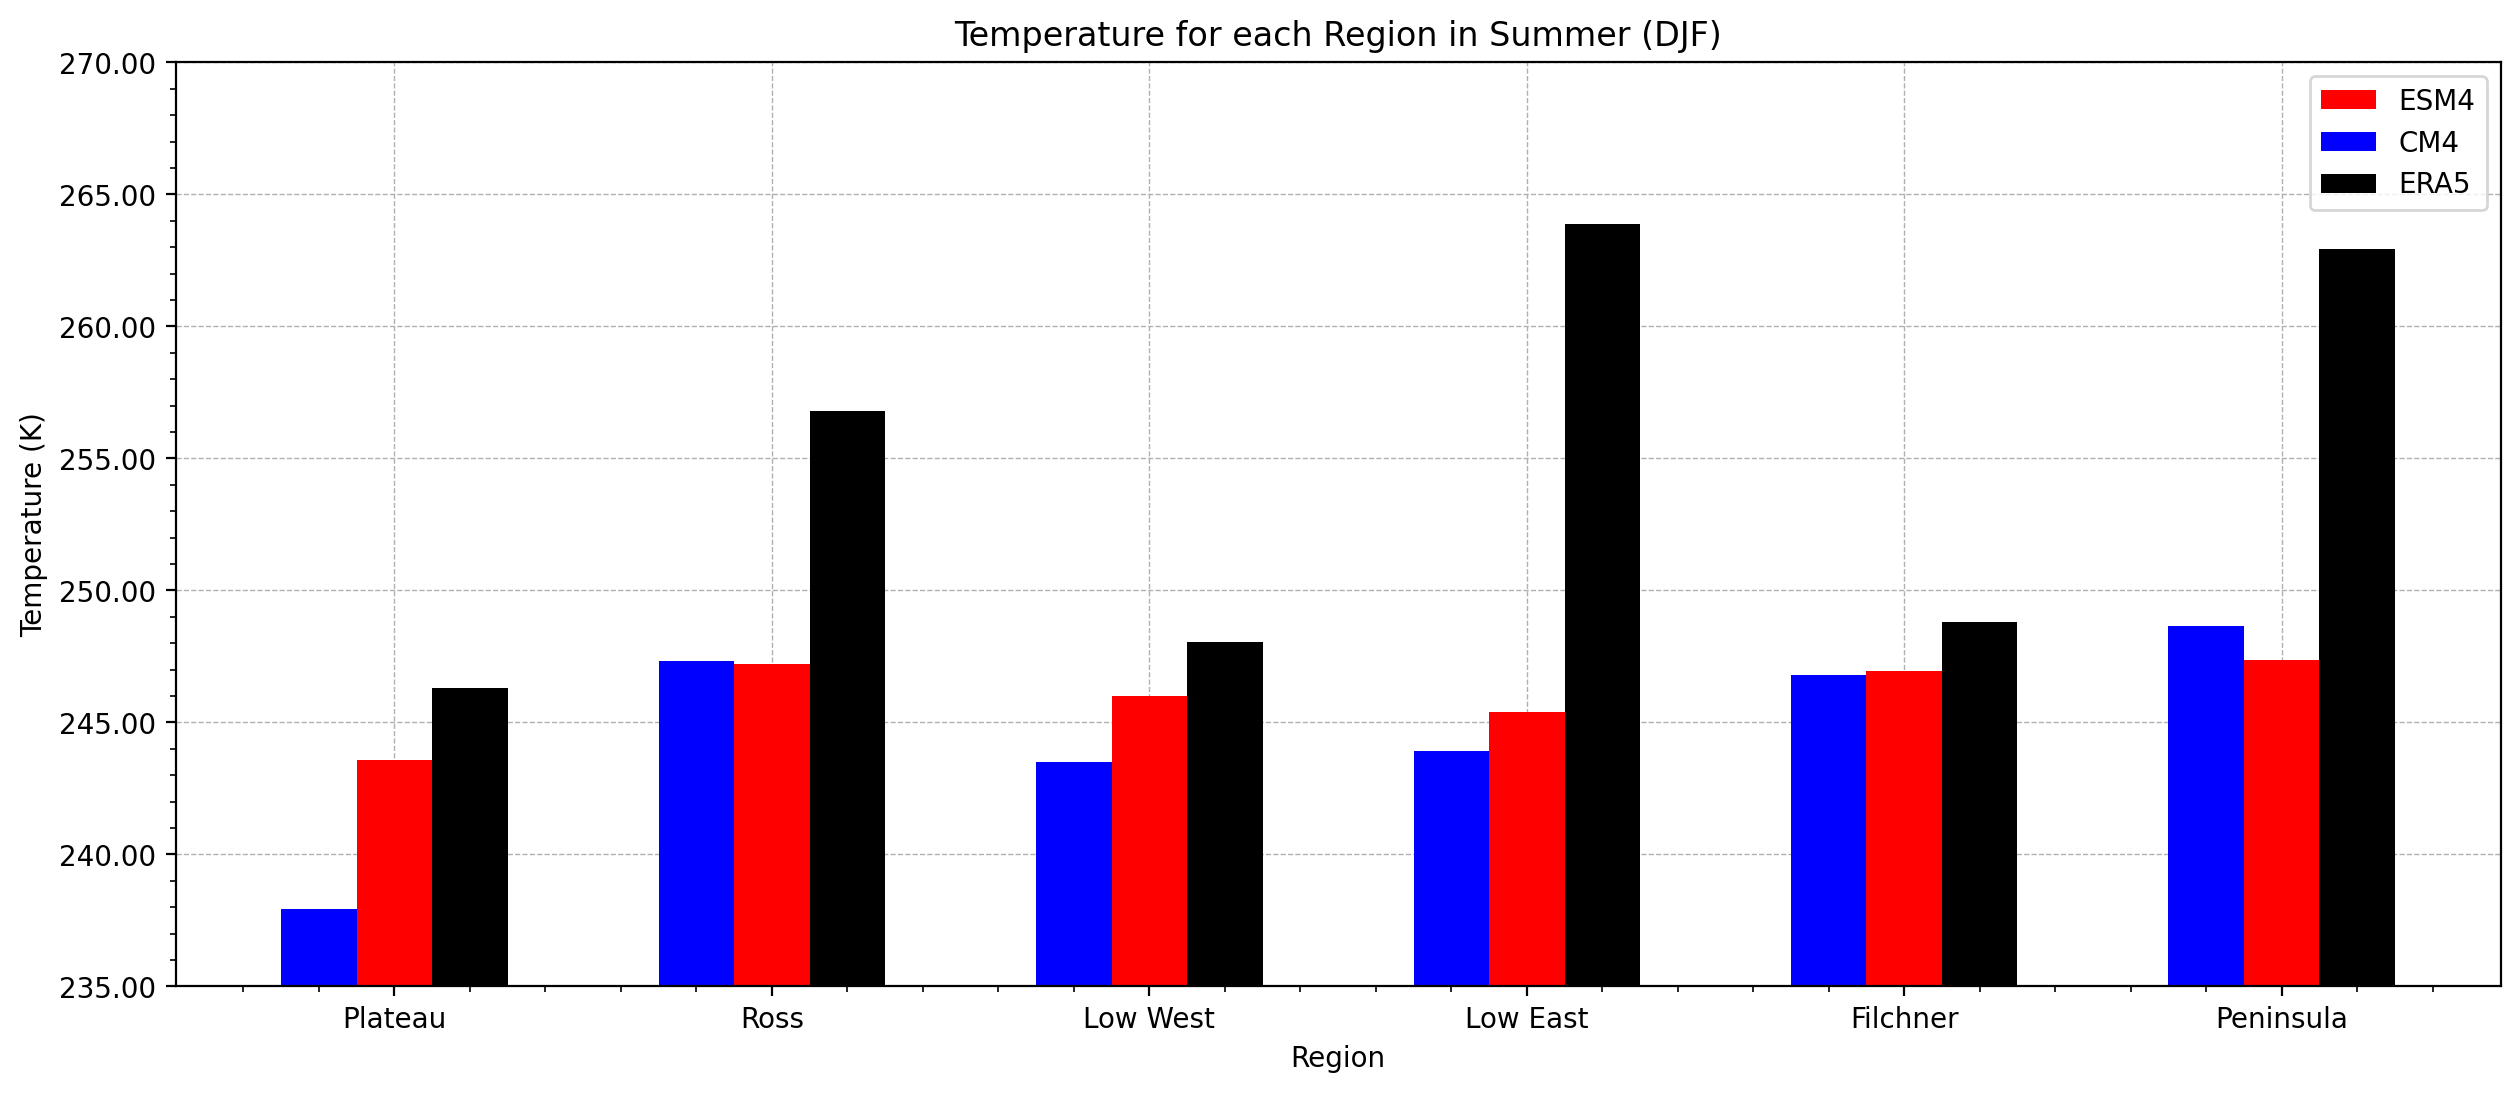

In [31]:

fig, ax= plt.subplots(figsize= (15,6))


X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4_summer = [237.9152,
247.34052,
243.50017,
243.92659,
246.79234,
248.6589] 
ESM4_summer = [243.57416,
247.21832,
245.98804,
245.40067,
246.96098,
247.35742] 

ERA5_summer=[246.32231,
256.81577,
248.0442,
263.89236,
248.80302,
262.91928
     ]
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4_summer, 0.2, label = 'ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4_summer, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA5_summer, 0.2, label= 'ERA5', color= 'k')
ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Temperature (K)") 
plt.title("Temperature for each Region in Summer (DJF)") 
plt.legend() 
plt.ylim(235,270)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.minorticks_on()
plt.show() 








# <span style="color:red">Winter Temp Plot</span>

In [32]:
plat_value_CM4_winter=print(plateau_temp_winter_CM4.values)
ross_value_CM4_winter= print(ross_temp_winter_CM4.values)
west_value_CM4_winter=print(lowwest_temp_winter_CM4.values)
east_value_CM4_winter=print(loweast_temp_winter_CM4.values)
filch_value_CM4_winter=print(filchner_temp_winter_CM4.values)
pen_value_CM4_winter=print(peninsula_temp_winter_CM4.values)

211.0074
221.2857
217.81888
222.40872
220.90349
228.88927


In [33]:
plat_value_ESM4_winter=print(plateau_temp_winter_ESM4.values)
ross_value_ESM4_winter= print(ross_temp_winter_ESM4.values)
west_value_ESM4_winterr=print(lowwest_temp_winter_ESM4.values)
east_value_ESM4_winter=print(loweast_temp_winter_ESM4.values)
filch_value_ESM4_winter=print(filchner_temp_winter_ESM4.values)
pen_value_ESM4_winter=print(peninsula_temp_winter_ESM4.values)

211.80536
219.6623
216.52388
221.16179
219.70515
225.01628


In [34]:
plat_value_ERA5_winter=print(plateau_temp_winter_ERA5.values)
ross_value_ERA5_winter= print(ross_temp_winter_ERA5.values)
west_value_ERA5_winterr=print(lowwest_temp_winter_ERA5.values)
east_value_ERA5_winter=print(loweast_temp_winter_ERA5.values)
filch_value_ERA5_winter=print(filchner_temp_winter_ERA5.values)
pen_value_ERA5_winter=print(peninsula_temp_winter_ERA5.values)

225.71474
236.12903
228.4483
249.23726
226.95349
249.80367


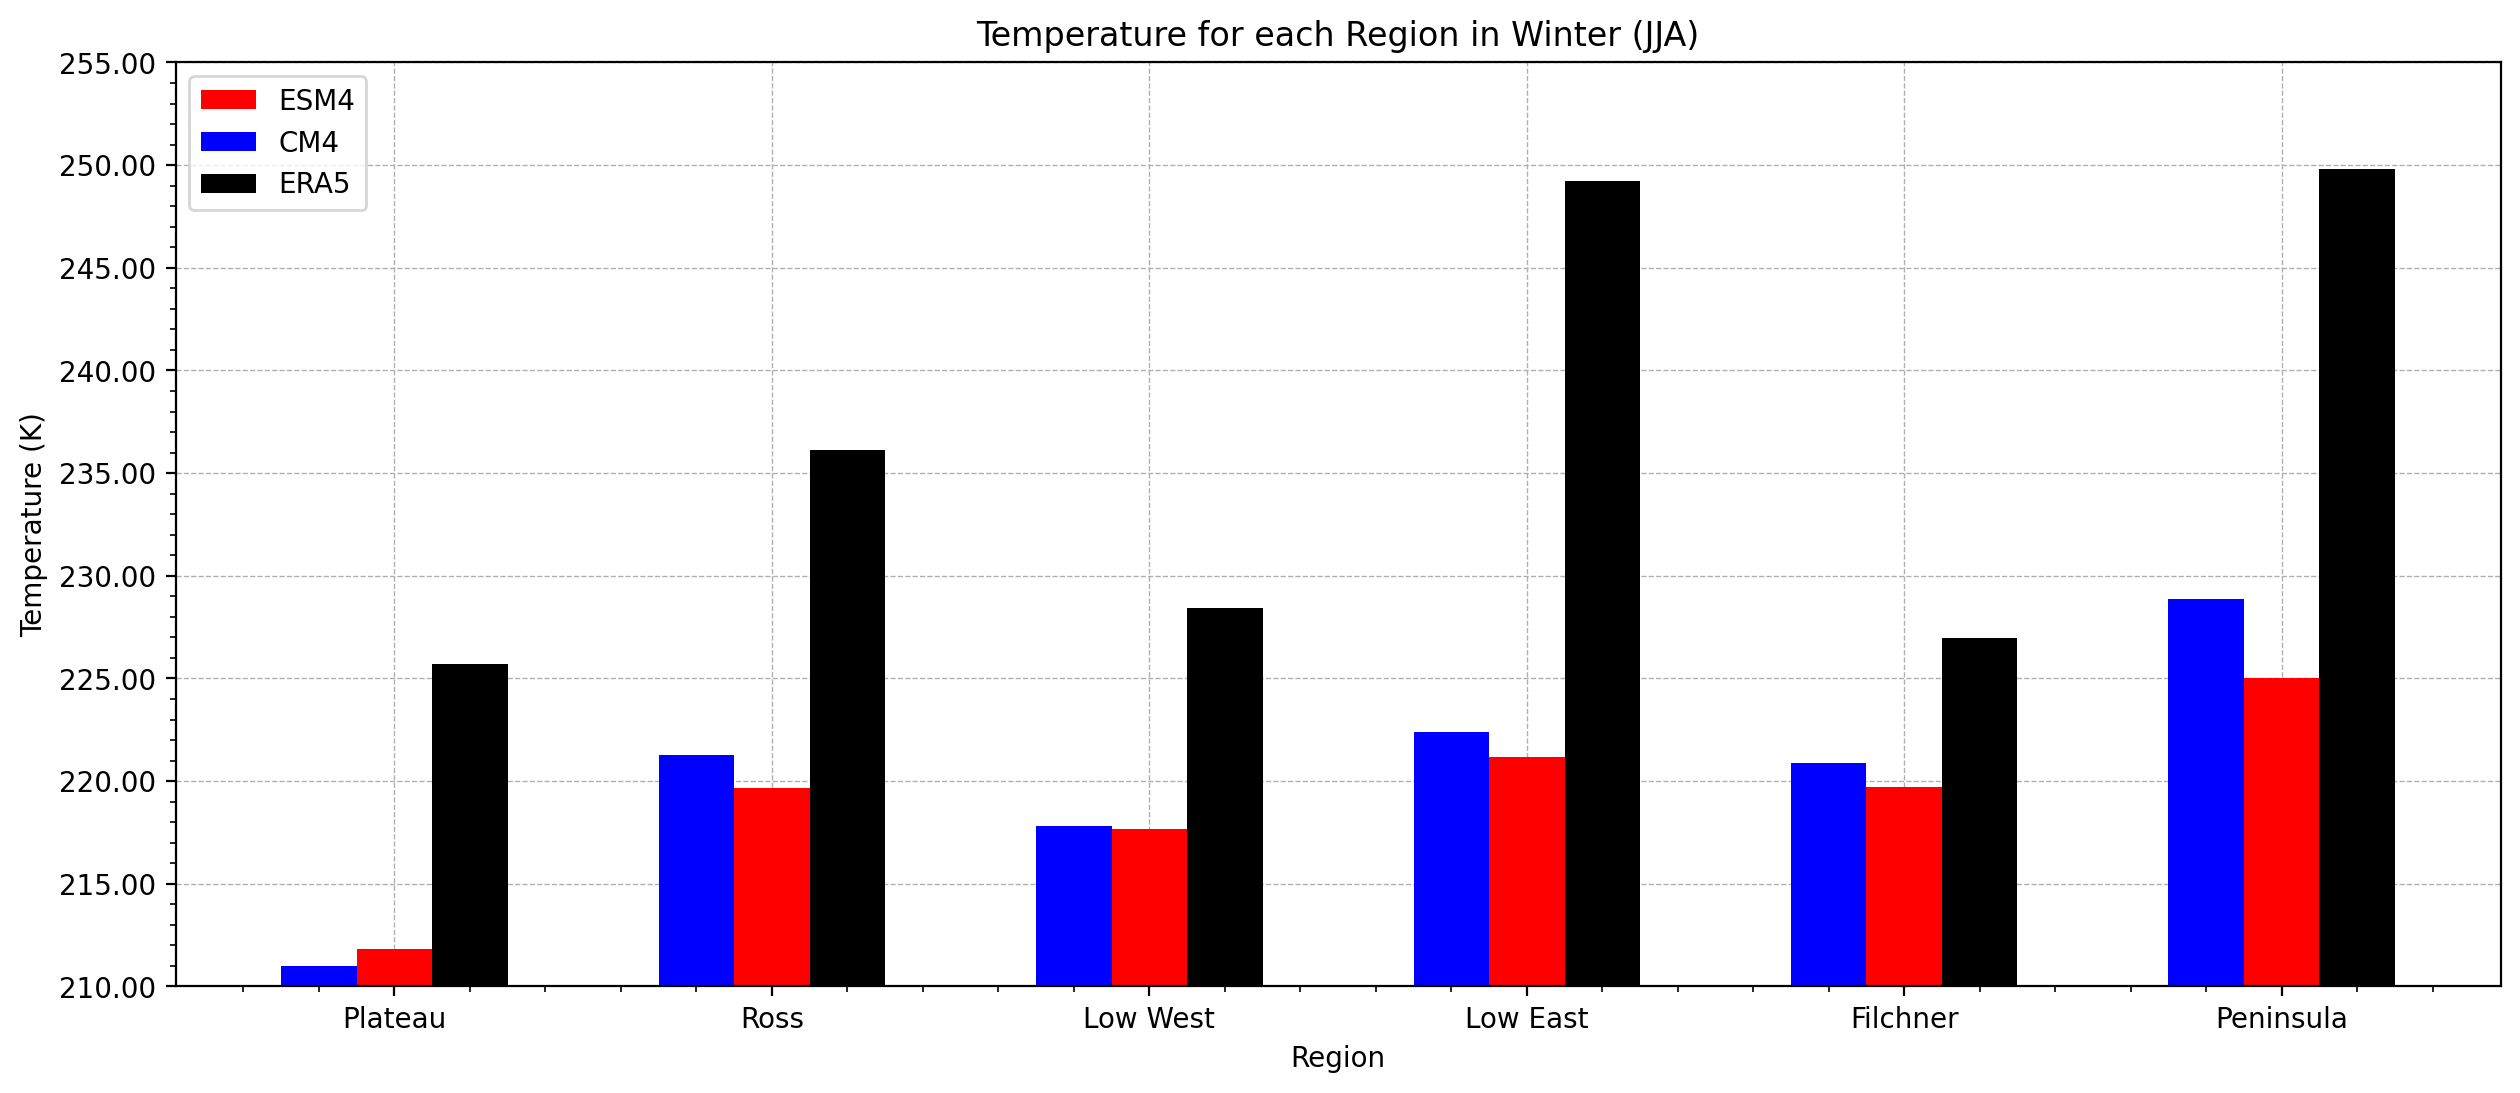

In [36]:

fig, ax= plt.subplots(figsize= (15,6))


X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4_winter = [211.0074,
221.2857,
217.81888,
222.40872,
220.90349,
228.88927
] 
ESM4_winter = [211.80536,
219.6623,
217.68489,
221.16179,
219.70515,
225.01628] 

ERA5_winter=[225.71474,
236.12903,
228.4483,
249.23726,
226.95349,
249.80367]

X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4_winter, 0.2, label = 'ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4_winter, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA5_winter, 0.2, label= 'ERA5', color= 'k')
ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Temperature (K)") 
plt.title("Temperature for each Region in Winter (JJA)") 
plt.legend() 
plt.ylim(210,255)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.minorticks_on()
plt.show() 








# <span style="color:red">Fall Temp Plot</span>

In [37]:
plat_value_CM4_fall=print(plateau_temp_fall_CM4.values)
ross_value_CM4_fall= print(ross_temp_fall_CM4.values)
west_value_CM4_fall=print(lowwest_temp_fall_CM4.values)
east_value_CM4_fall=print(loweast_temp_fall_CM4.values)
filch_value_CM4_fall=print(filchner_temp_fall_CM4.values)
pen_value_CM4_fall=print(peninsula_temp_fall_CM4.values)

223.2136
233.22324
229.8781
232.38487
232.41486
238.96733


In [38]:
plat_value_ESM4_fall=print(plateau_temp_fall_ESM4.values)
ross_value_ESM4_fall= print(ross_temp_fall_ESM4.values)
west_value_ESM4_fall=print(lowwest_temp_fall_ESM4.values)
east_value_ESM4_fall=print(loweast_temp_fall_ESM4.values)
filch_value_ESM4_fall=print(filchner_temp_fall_ESM4.values)
pen_value_ESM4_fall=print(peninsula_temp_fall_ESM4.values)

224.55159
230.71411
228.16249
230.75299
230.25726
233.87589


In [39]:
plat_value_ERA5_fall=print(plateau_temp_fall_ERA5.values)
ross_value_ERA5_fall= print(ross_temp_fall_ERA5.values)
west_value_ERA5_fall=print(lowwest_temp_fall_ERA5.values)
east_value_ERA5_fall=print(loweast_temp_fall_ERA5.values)
filch_value_ERA5_fall=print(filchner_temp_fall_ERA5.values)
pen_value_ERA5_fall=print(peninsula_temp_fall_ERA5.values)

229.3289
240.89078
232.17006
253.95432
230.47618
253.60771


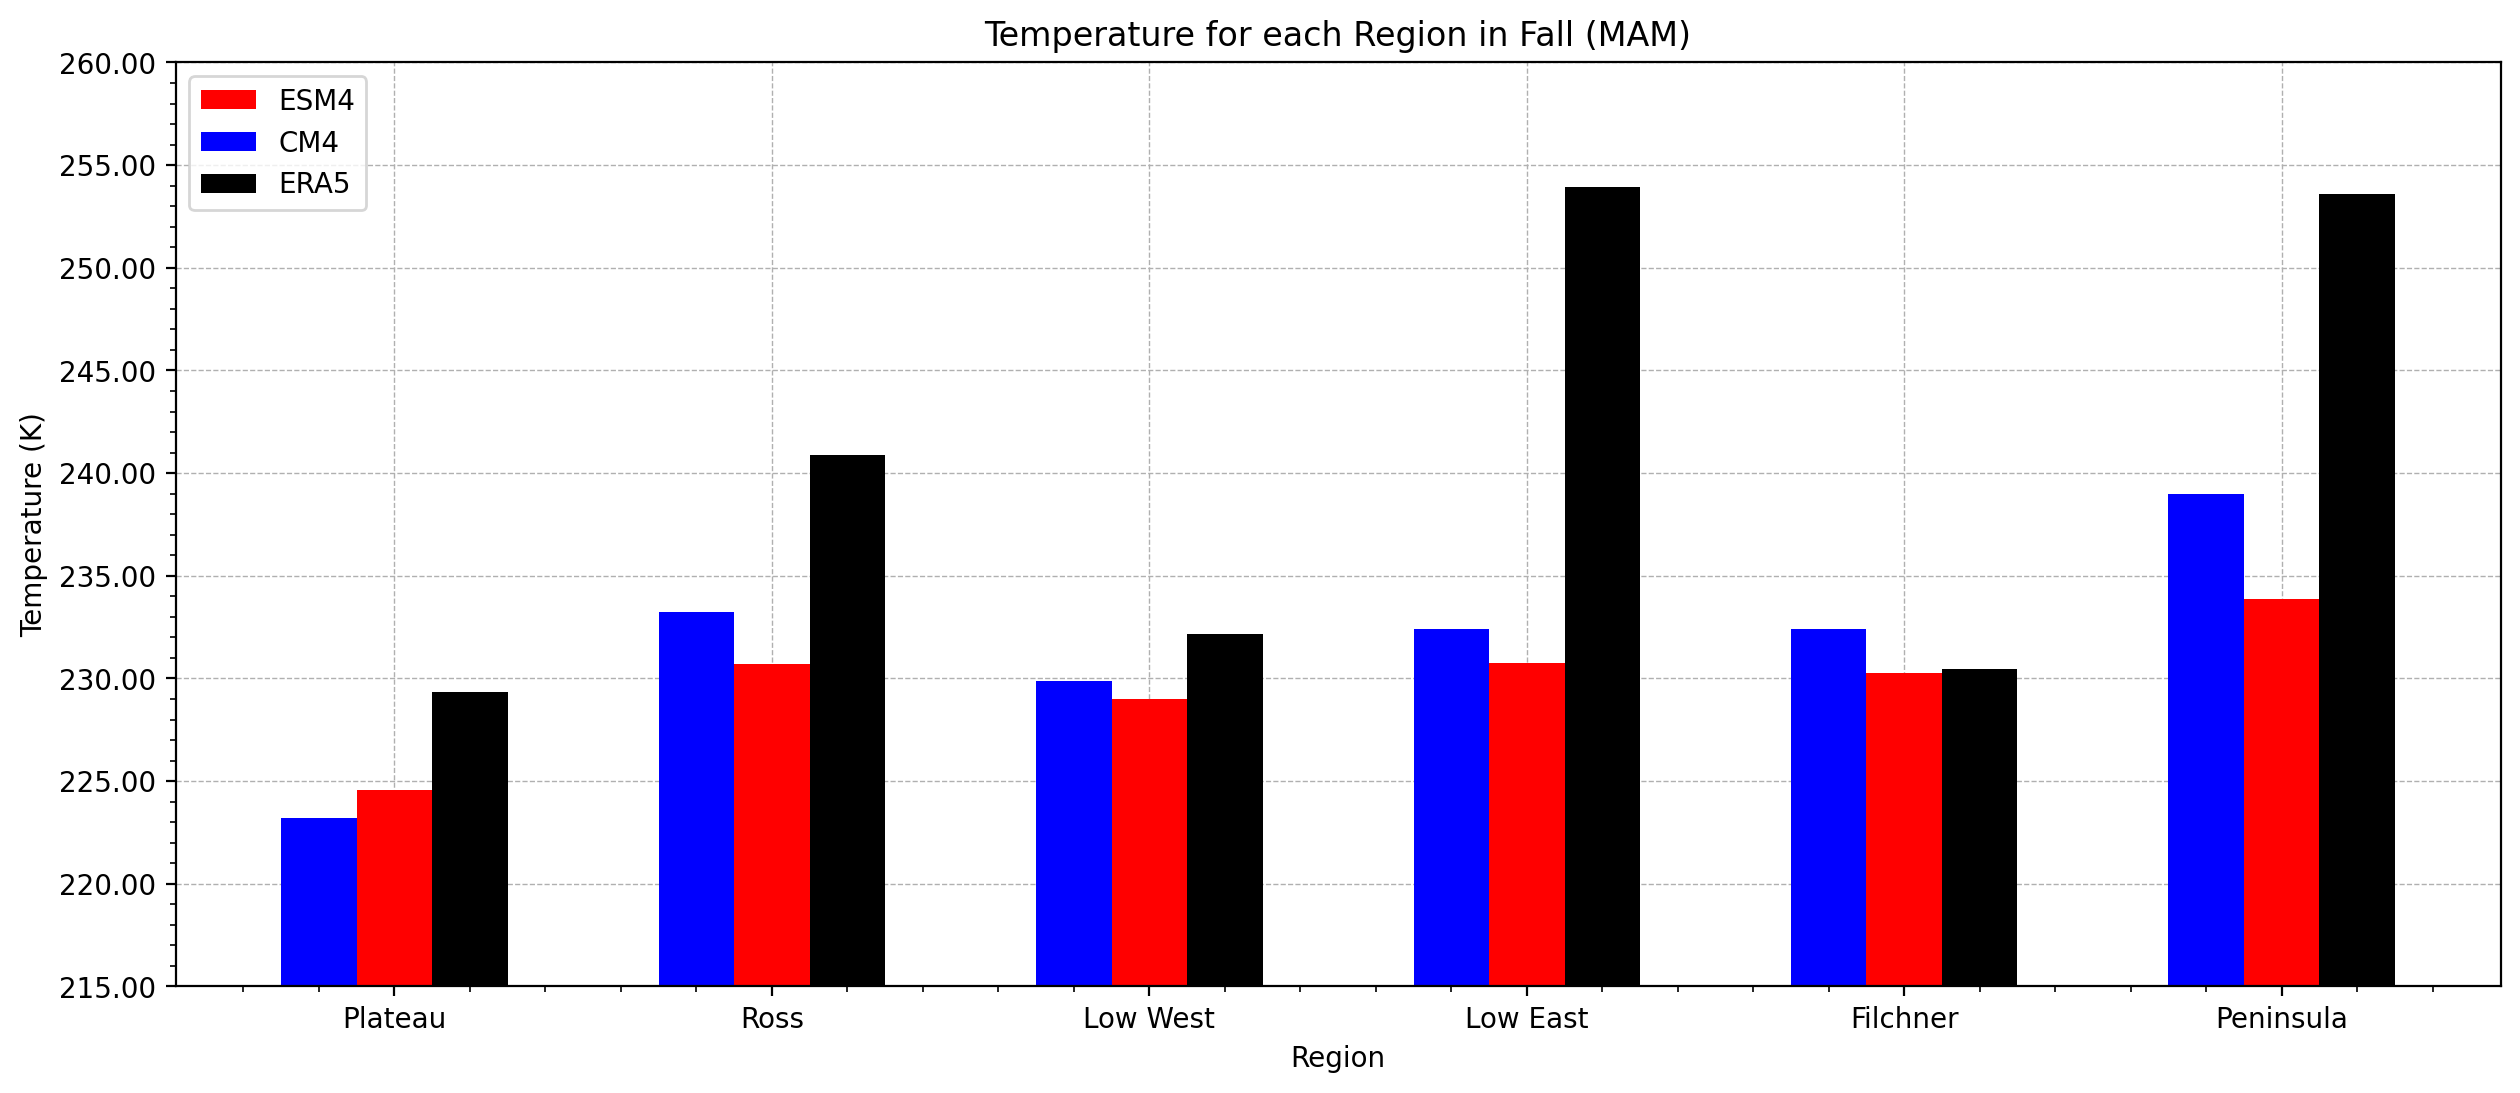

In [41]:

fig, ax= plt.subplots(figsize= (15,6))


X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4_fall = [223.2136,
233.22324,
229.8781,
232.38487,
232.41486,
238.96733
] 
ESM4_fall = [224.55159,
230.71411,
228.98859,
230.75299,
230.25726,
233.87589] 

ERA5_fall = [229.3289,
240.89078,
232.17006,
253.95432,
230.47618,
253.60771
]

X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4_fall, 0.2, label = 'ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4_fall, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA5_fall, 0.2, label= 'ERA5', color= 'k')
ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Temperature (K)") 
plt.title("Temperature for each Region in Fall (MAM)") 
plt.legend() 
plt.ylim(215,260)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.minorticks_on()
plt.show() 








# <span style="color:red">Spring Temp Plot</span>

In [42]:
plat_value_CM4_spring=print(plateau_temp_spring_CM4.values)
ross_value_CM4_spring= print(ross_temp_spring_CM4.values)
west_value_CM4_spring=print(lowwest_temp_spring_CM4.values)
east_value_CM4_spring=print(loweast_temp_spring_CM4.values)
filch_value_CM4_spring=print(filchner_temp_spring_CM4.values)
pen_value_CM4_spring=print(peninsula_temp_spring_CM4.values)

223.15291
234.00923
229.2303
233.37134
231.93024
237.83176


In [43]:
plat_value_ESM4_spring=print(plateau_temp_spring_ESM4.values)
ross_value_ESM4_spring= print(ross_temp_spring_ESM4.values)
west_value_ESM4_spring=print(lowwest_temp_spring_ESM4.values)
east_value_ESM4_spring=print(loweast_temp_spring_ESM4.values)
filch_value_ESM4_spring=print(filchner_temp_spring_ESM4.values)
pen_value_ESM4_spring=print(peninsula_temp_spring_ESM4.values)

230.66292
235.07298
232.92633
235.81972
234.6562
237.28159


In [44]:
plat_value_ERA5_spring=print(plateau_temp_spring_ERA5.values)
ross_value_ERA5_spring= print(ross_temp_spring_ERA5.values)
west_value_ERA5_spring=print(lowwest_temp_spring_ERA5.values)
east_value_ERA5_spring=print(loweast_temp_spring_ERA5.values)
filch_value_ERA5_spring=print(filchner_temp_spring_ERA5.values)
pen_value_ERA5_spring=print(peninsula_temp_spring_ERA5.values)

233.21788
243.6683
235.548
254.40582
235.39291
254.72002


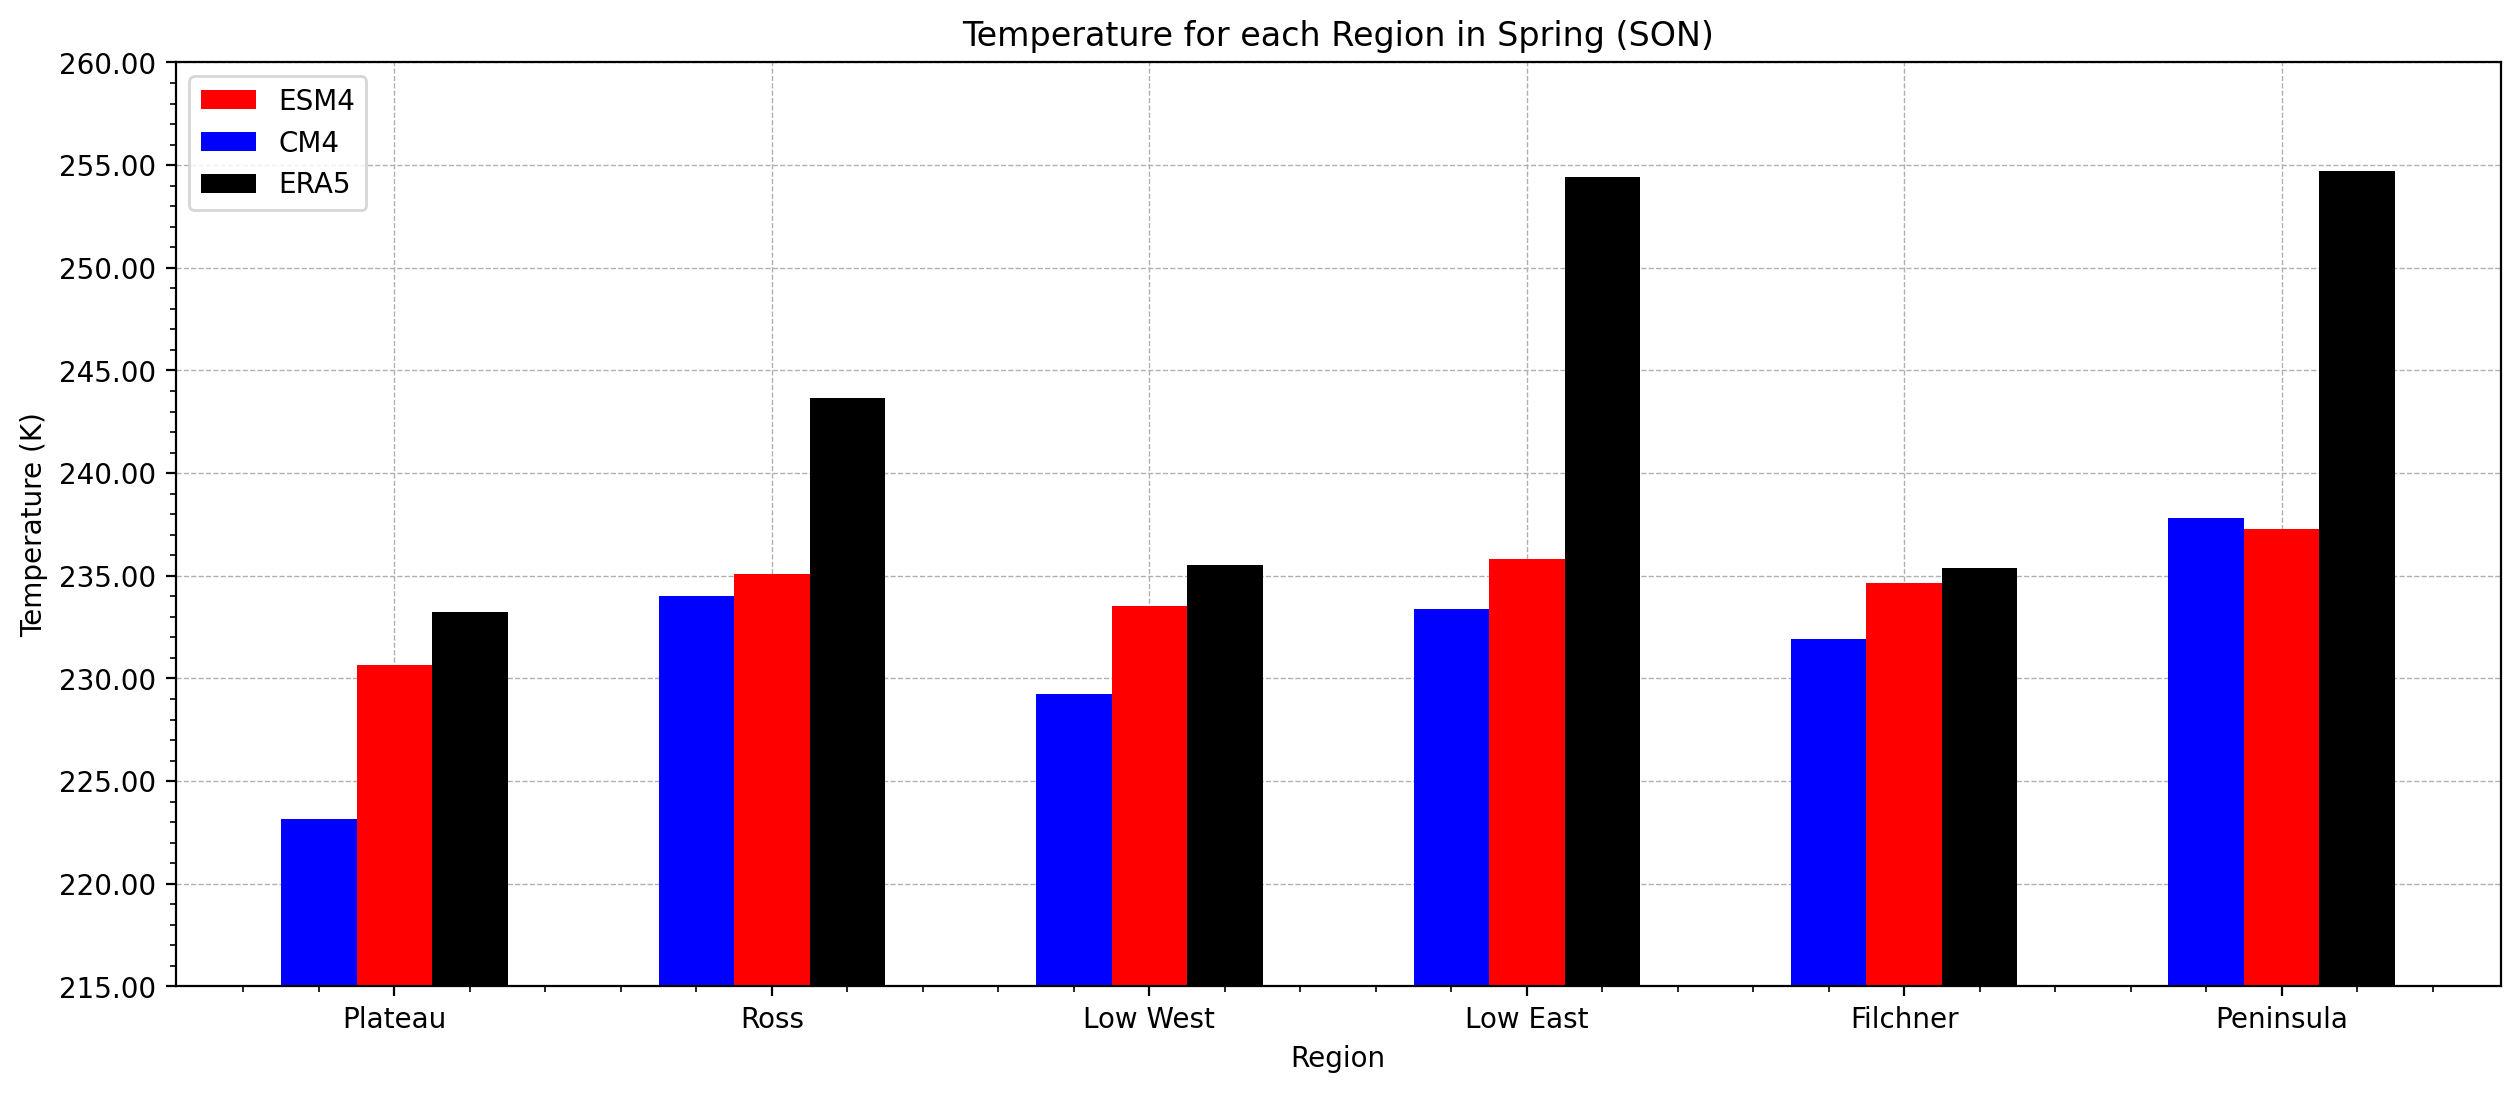

In [46]:

fig, ax= plt.subplots(figsize= (15,6))


X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4_spring = [223.15291,
234.00923,
229.2303,
233.37134,
231.93024,
237.83176
] 
ESM4_spring = [230.66292,
235.07298,
233.54503,
235.81972,
234.6562,
237.28159] 

ERA5_spring=[233.21788,
243.6683,
235.548,
254.40582,
235.39291,
254.72002
]
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4_spring, 0.2, label = 'ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4_spring, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA5_spring, 0.2, label= 'ERA5', color= 'k')
ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Temperature (K)") 
plt.title("Temperature for each Region in Spring (SON)") 
plt.legend() 
plt.ylim(215,260)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.minorticks_on()
plt.show() 





